<p><font size="6"><b>Introduction to geospatial raster data in Python</b></font></p>


> *DS Python for GIS and Geoscience*  
> *September, 2024*
>
> *© 2024, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
%matplotlib inline

import numpy as np

The two primary types of geospatial data are raster and vector data. Vector data structures represent specific features on the Earth’s surface, and assign attributes to those features. 

__Raster data__ is stored as a grid of values which are rendered on a map as pixels. Raster files are different from photographs in that they are spatially referenced. Each pixel represents an area of land on the ground. That area is defined by the spatial resolution of the raster.

![](../img/raster-concept.png)

<small>_Source: Colin Williams, NEON._</small>

Raster data contains at least 3 dimensions:

- longitude of the pixel 
- latitude of the pixel 
- data value(s) of the pixel

The data value can be a single data point for each pixel, also called a single band (or layer) raster data set. A well-known single-band raster data set is a Digital Elevation Model (DEM): each pixel data value in a DEM represents the surface elevation of the area represented by the pixel. 

Each pixel can also contain multiple data values, i.e. multiple bands (or layers). Remote sensing measurement are typically raster data sets that consist out of multiple bands. For example, bands 2, 3, and 4 of the [Landsat 8](https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands) measurements capture respectively visible blue, green, and red (each with a resolution of 30m).

Whereas we could actually store raster data as a tabular data set using an x, y and value column, the representation as a N-d array/grid is more convenient for raster data handling. 

Similar to the GeoPandas library for feature based data, meet [xarray](http://xarray.pydata.org/en/stable/) for raster based data.

## Importing raster data

Just like geospatial feature based (vector) data, raster data is available from specific GIS file formats or data stores, like Geotiff files, Esri grid, NetCDF files, PostGIS (PostgreSQL) database, ...

We can use the xarray library to read many of those GIS file formats (relying on the [Rasterio library](https://rasterio.readthedocs.io/en/latest/) under the hood, which is an interface to raster data). An important data format is GeoTiff. 

Let's start with reading the Sentinel RGB bands for Herstappe:

In [2]:
import xarray as xr

In [3]:
file_herstappe = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [4]:
herstappe = xr.open_dataarray(file_herstappe, engine="rasterio")
herstappe

<xarray.DataArray 'band_data' (band: 3, y: 227, x: 447)> Size: 1MB
[304407 values with dtype=float32]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 4kB 5.935e+05 5.935e+05 ... 6.113e+05 6.114e+05
  * y            (y) float64 2kB 6.578e+06 6.577e+06 ... 6.569e+06 6.568e+06
    spatial_ref  int64 8B ...
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area

Xarray brings its own plotting methods, but relies on Matplotlib for the actual plotting:

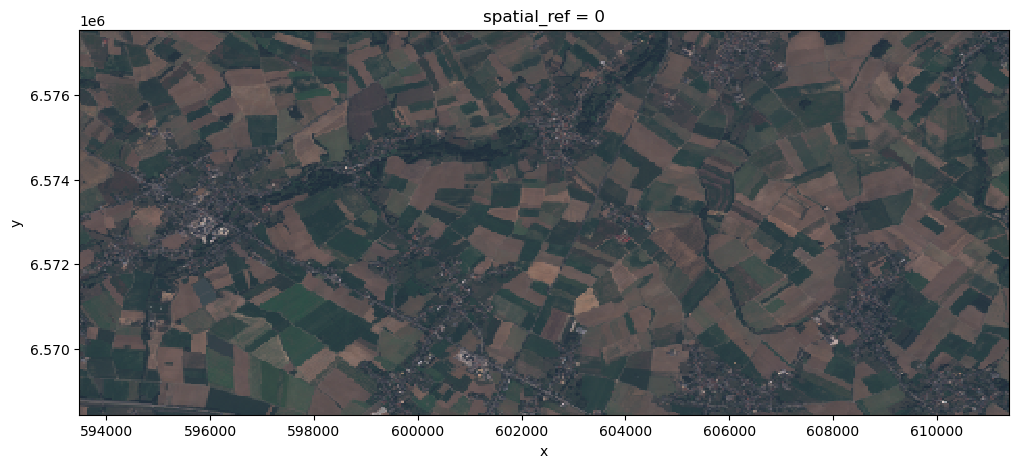

In [5]:
ax = herstappe.plot.imshow(figsize=(12, 5))
#ax.axes.set_aspect('equal')  # adjust the ratio of y-unit to x-unit, using 'esual' uses the same scaling for x and y, 

A raster is an __image__ in local pixel coordinates until we specify what part of the earth the image covers. This is done through the usage of raster file metadata. It depends on the file type how these are stored on disk. When reading in a file, the metadata need to be interpreted as well in order to know the __spatial information__. The translation from the data and metadata to a Python Nd-array with geographical context is done by the rasterio/xarray packages.

As an quick introduction (we will learn the specific syntax later).

> Plot of the Red band only, using a Red color scale_

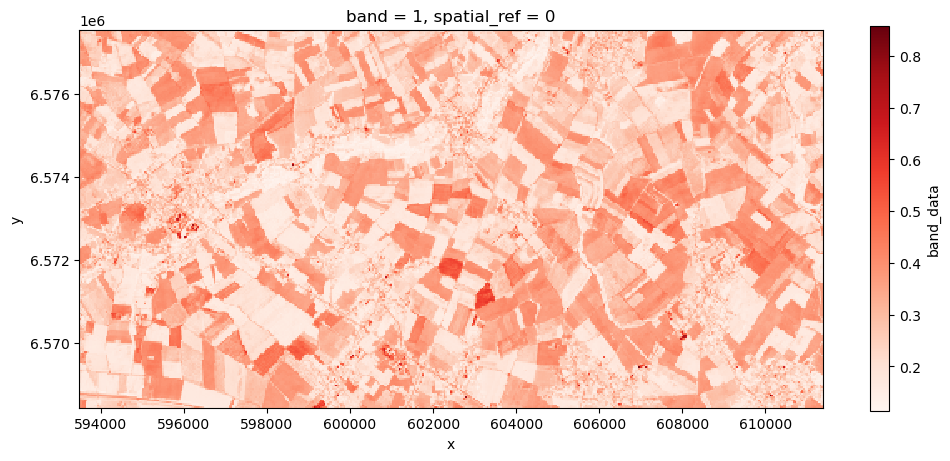

In [6]:
ax = herstappe.sel(band=1).plot.imshow(cmap="Reds", figsize=(12, 5))  #, robust=True)
ax.axes.set_aspect('equal')

> _plot the intersection of the data at x coordinate closest to 600000 for each band:_

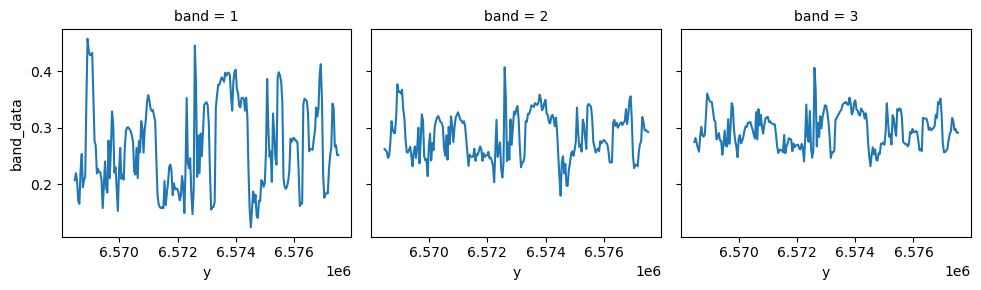

In [7]:
herstappe.sel(x=600_000, method='nearest').plot.line(col='band')

## What's a xarray.DataArray?

Let's have a look at the data again:

In [8]:
herstappe

<xarray.DataArray 'band_data' (band: 3, y: 227, x: 447)> Size: 1MB
[304407 values with dtype=float32]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 4kB 5.935e+05 5.935e+05 ... 6.113e+05 6.114e+05
  * y            (y) float64 2kB 6.578e+06 6.577e+06 ... 6.569e+06 6.568e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area

The output of xarray is a bit different to what we've previous seen. Let's go through the different elements:

- It is a `xarray.DataArray`, one of the main data types provided by xarray
- It has 3 __dimensions__:
    - `band`: 3 bands (in this case RGB)
    - `y`: the y coordinates of the data set
    - `x`: the x coordinates of the data set
- Each of these dimensions are defined by a __coordinate__ (1D) array
- It contains 304407 (227\*447\*3) data values (stored as float32)
- Other metadata, such as some of the metadata provided by the `tiff` file are stored in the __`Attributes`__. The attributes is a dictionary.

Looking to the data itself (click on the icons on the right), we can see these are Numpy arrays...

## Xarray adds (spatial) context to NumPy arrays

Both the data values as the values of the coordinates are...

In [9]:
type(herstappe.values), type(herstappe.x.values), type(herstappe.y.values), type(herstappe.band.values)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

... all Numpy arrays! 

Numpy is on of the most fundamental parts of the scientific python 'ecosystem'. A lot of other packages - you already used Pandas and GeoPandas in this course, and now also xarray - are built on top of NumPy and the ndarray (n-dimensional array) object it provides.

When you read raster data using `xarray.open_dataarray` you are actually creating a set of Numpy arrays combined in a `xarray.DataArray` object. A Numpy array is an efficient data type to calculate with arrays in general. Let's extract the data of herstappe as an Numpy `ndarray`:

In [10]:
herstappe_array = herstappe.values

In [11]:
herstappe_array

array([[[0.3375 , 0.2195 , 0.17675, ..., 0.167  , 0.17625, 0.2485 ],
        [0.362  , 0.29525, 0.222  , ..., 0.197  , 0.21275, 0.27125],
        [0.30775, 0.26425, 0.25875, ..., 0.272  , 0.28975, 0.27425],
        ...,
        [0.39175, 0.38825, 0.4335 , ..., 0.3815 , 0.3135 , 0.2055 ],
        [0.38625, 0.40475, 0.42125, ..., 0.39725, 0.3875 , 0.3235 ],
        [0.3905 , 0.40375, 0.41775, ..., 0.386  , 0.388  , 0.38725]],

       [[0.311  , 0.2525 , 0.239  , ..., 0.22525, 0.2315 , 0.24775],
        [0.3485 , 0.312  , 0.25725, ..., 0.23625, 0.25475, 0.29   ],
        [0.31375, 0.27775, 0.27775, ..., 0.28725, 0.30475, 0.26975],
        ...,
        [0.342  , 0.34175, 0.36575, ..., 0.33725, 0.30925, 0.25075],
        [0.34225, 0.3465 , 0.35675, ..., 0.3415 , 0.338  , 0.31475],
        [0.3405 , 0.35075, 0.35925, ..., 0.33625, 0.341  , 0.349  ]],

       [[0.3235 , 0.277  , 0.26   , ..., 0.25075, 0.266  , 0.27925],
        [0.35775, 0.31775, 0.285  , ..., 0.276  , 0.28525, 0.31625],
    

In [12]:
type(herstappe_array), herstappe_array.dtype

(numpy.ndarray, dtype('float32'))

In [13]:
type(herstappe.x.values), type(herstappe.y.values)

(numpy.ndarray, numpy.ndarray)

NumPy supports different dtypes (float, int,...), but __all elements of an array do have the same dtype__. Note that NumPy auto-detects the data-type from the input. The data type of this specific array `herstappe_array` is float32. More information on the data types NumPy supports is available in the [documentation](https://numpy.org/devdocs/user/basics.types.html#array-types-and-conversions-between-types).

Just as any other object in Python, the `ndarray` has a number of attributes. We already checked the `dtype` attribute. The `shape` and `ndim` of the array are other relevant attributes:

In [14]:
herstappe_array.shape, herstappe_array.ndim

((3, 227, 447), 3)

Hence, we have three bands with dimensions (227, 447) and data type float32. But with this single Numpy array, we do not have any spatial information on which area of the earth this data represents. We also need the `herstappe.x` and `herstappe.y` arrays to link the indidivual elements in the array with the corresponding earth coordinates and band. 

By using the `xarray.DataArray` to wrap and combine these NumPy arrays, we can keep the data and the spatial context together.

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**:

The [`numpy` package](https://numpy.org/) is the backbone of the scientific Python ecosystem. The `ndarray` provides an efficient data type to store and manipulate raster data, but it does __NOT contain any spatial information__. 
    
If we use `xarray.DataArray` to wrap this NumPy array, we can keep the data and the spatial context together.

</div>

## Raster data attributes - spatial context

To quickly scan the spatial metadata of a Raster data file, let's use the [`gdalinfo` command](https://gdal.org/programs/gdalinfo.html#gdalinfo). 

> The `gdalinfo` command lists information about a raster dataset.

It is not a Python command, but a program that need to be run from the terminal (aka command line). Using a small Jupyter notebook - `!` trick, we can use it within the notebook as well:

In [15]:
!gdalinfo -mm ./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff

Warning 1: PROJ: proj_create_from_database: datum not found: EPSG:1
Warning 1: PROJ: proj_create_from_database: ellipsoid not found: EPSG:1
Warning 1: The definition of geographic CRS EPSG:4326 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Driver: GTiff/GeoTIFF
Files: ./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff
Size is 447, 227
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["unnamed",
        METHO

Important information we get from the `gdalinfo` command are 

* Coordinate reference system (CRS), see also [02-coordinate-reference-systems notebook](./02-coordinate-reference-systems.ipynb).
* Number of bands in the data set: A data set can contain one (single) or more (multi) layers (bands).
* Spatial resolution: This resolution represents the area on the ground that each pixel covers. The units for your data are determined by the CRS above (e.g. meters).
* Spatial extent (bounding box) of the data: The geographic area that the raster data covers.

<img src="../img/raster-spatial-extent-coordinates.png" alt="spatial-extnet" style="width:500px;"/>

<small>_Image Source: National Ecological Observatory Network (NEON)._</small>

Let's see how `xarray.open_dataarray` interprets this information:

In [16]:
herstappe = xr.open_dataarray(file_herstappe, engine="rasterio")
herstappe

<xarray.DataArray 'band_data' (band: 3, y: 227, x: 447)> Size: 1MB
[304407 values with dtype=float32]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 4kB 5.935e+05 5.935e+05 ... 6.113e+05 6.114e+05
  * y            (y) float64 2kB 6.578e+06 6.577e+06 ... 6.569e+06 6.568e+06
    spatial_ref  int64 8B ...
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area

- Coordinate reference system (CRS) stored as attribute to the `xr.DataArray` `rio` accessor:

In [17]:
herstappe.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]')

In [18]:
type(herstappe.rio.crs) # herstappe.rio.crs.to_string(), # herstappe.rio.crs.to_wkt()

rasterio.crs.CRS

- Number of bands in the data set. Each band in the original data set is represented in the `band` dimension:

In [19]:
herstappe.band

<xarray.DataArray 'band' (band: 3)> Size: 24B
array([1, 2, 3])
Coordinates:
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B ...

- Spatial resolution: This resolution represents the area on the ground that each pixel covers. It is available with the `rio`  accessor, but also translated to the coordinates dimensions x and y as the distance between two elements:

In [20]:
herstappe.rio.resolution()

(40.07813983073409, -40.1126034998577)

In [21]:
herstappe.x[1] - herstappe.x[0], herstappe.y[1] - herstappe.y[0]

(<xarray.DataArray 'x' ()> Size: 8B
 array(40.07813983)
 Coordinates:
     spatial_ref  int64 8B 0,
 <xarray.DataArray 'y' ()> Size: 8B
 array(-40.1126035)
 Coordinates:
     spatial_ref  int64 8B 0)

- Spatial extent (bounding box) of the data. [Xarray translates](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) the the coordinates info and spatial extent:

    >  The x and y coordinates are generated automatically from the file’s geoinformation, shifted to the center of each pixel.
    
Hence, the minimal and maximum values of the coordinates are still the same as the boundaries defined by the metadata:

In [22]:
herstappe.rio.bounds()

(593476.1968631798, 6568444.042372981, 611391.125367518, 6577549.60336745)

In [23]:
herstappe.x.min(), herstappe.x.max(), herstappe.y.min(), herstappe.y.max()

(<xarray.DataArray 'x' ()> Size: 8B
 array(593496.2359331)
 Coordinates:
     spatial_ref  int64 8B ...,
 <xarray.DataArray 'x' ()> Size: 8B
 array(611371.0862976)
 Coordinates:
     spatial_ref  int64 8B ...,
 <xarray.DataArray 'y' ()> Size: 8B
 array(6568464.09867473)
 Coordinates:
     spatial_ref  int64 8B ...,
 <xarray.DataArray 'y' ()> Size: 8B
 array(6577529.5470657)
 Coordinates:
     spatial_ref  int64 8B ...)

<div class="alert alert-info" style="font-size:120%">

**TIP**: <br>

The [`gdal` library](https://gdal.org/) is a very powerful set of functions. It is the
open source Swiss Army knife for raster and vector geospatial data handling. GDAL provides Python bindings to run it from Python code, but these are not very 'Pythonic'. When familiar with the command line the [command line raster functions](https://gdal.org/programs/index.html#raster-programs) (CLI) are certainly worthwhile to check out!
    
You can run a CLI command inside a Jupyter Notebook by prefixing it with the `!` character.

</div>